# Effectiveness of the time extension method on the Lorenz system

# Combined Bachelor Thesis (NS-320B), June 2022
## Mathematics & Physics and Astronomy
*'Applying Physics-informed Neural Networks to Chaotic Systems of Ordinary Differential Equations'*

**Author:** Martijn Sebastiaan Brouwer (6859488)

**Mathematics supervisors:** prof. dr. ir. C.W. Oosterlee

**Physics supervisor:** dr. J. de Graaf

**PhD supervisor:** B. Negyesi

## Importing packages and making directories

In [1]:
!mkdir plots
!mkdir plots_x
!mkdir plots_y
!mkdir plots_z

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
import pickle
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(1234)
np.random.seed(1234)

## Definitions 
### (Fully Connected Network (FCN), Runge-Kutta fourth order method, plotting and saving animated gifs)

In [2]:
# ----------------------------------------------------------------------------- 
# -------------------------- Fully Connected Network --------------------------
# ----------------------------------------------------------------------------- 
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going through the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x


# ----------------------------------------------------------------------------- 
# ---------------------- Runge-Kutta fourth order method ---------------------- 
# ----------------------------------------------------------------------------- 
def RungeKutta(dxdt,dydt,dzdt, x0,y0,z0, ti,tf,n): # Specify derivatives, initial conditions and time
    h = tf/n #Step size
    xl,yl,zl = n*[0],n*[0],n*[0] #Create lists for output
    xl[0],yl[0],zl[0] = x0,y0,z0 #First element in output-list is the initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x,y,z = xl[i-1],yl[i-1],zl[i-1]
        #Going through the four RK4 equations:
        k1x,k1y,k1z = (h*f(x,y,z)    for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k1x,k1y,k1z,h)))
        k2x,k2y,k2z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + 0.5*kr    for r,kr in zip((x,y,z),(k2x,k2y,k2z,h)))
        k3x,k3y,k3z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        xs,ys,zs    = (r + kr        for r,kr in zip((x,y,z),(k3x,k3y,k3z,h)))
        k4x,k4y,k4z = (h*f(xs,ys,zs) for f in (dxdt,dydt,dzdt))
        #Update last next value in output list:
        xl[i],yl[i],zl[i] = (r + (k1r + 2*k2r + 2*k3r + k4r)/6 for r,k1r,k2r,k3r,k4r in 
                zip((x,y,z),(k1x,k1y,k1z),(k2x,k2y,k2z),(k3x,k3y,k3z),(k4x,k4y,k4z)))
    return xl,yl,zl

# ----------------------------------------------------------------------------- 
# -------------- 3D plot of RK4 approximation and PINN prediction ------------- 
# ----------------------------------------------------------------------------- 
def plot_result(x1,y1,z1, x2,y2,z2, x3,y3,z3, x_data,y_data,z_data, xh1,yh1,zh1, xh2,yh2,zh2, xh3,yh3,zh3):
    fig = plt.figure(figsize=(13,4.5))

    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.plot(x1,y1,z1, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    ax.plot(xh1,yh1,zh1, color="tab:blue", linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x_data, y_data, z_data, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    ax.set_title(f'Small time scale \n $t_f$ = {tf1}', fontsize="xx-large", pad=15)
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    ax.text2D(-0.04, -0.12, "Loss1 = {:.2e}".format(loss1_1), fontsize="x-large", color="k")
    ax.text2D(-0.04, -0.135, "Loss2 = {:.2e}".format(loss2_1), fontsize="x-large", color="k")

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    ax.plot(x2,y2,z2, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    ax.plot(xh2,yh2,zh2, color="tab:blue", linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x_data, y_data, z_data, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    ax.set_title(f'Larger time scale \n $t_f$ = {tf2}', fontsize="xx-large", pad=15)
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    ax.text2D(-0.04, -0.12, "Loss1 = {:.2e}".format(loss1_2), fontsize="x-large", color="k")
    ax.text2D(-0.04, -0.135, "Loss2 = {:.2e}".format(loss2_2), fontsize="x-large", color="k")
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.plot(x3,y3,z3, color="black", linewidth=1, alpha=0.8, label="RK4 approximation")
    ax.plot(xh3,yh3,zh3, color="tab:blue", linewidth=2, alpha=0.8, label="PiNN prediction")
    ax.scatter(x_data, y_data, z_data, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    ax.set_title('Time extension method \n $t_f$ = {:.1f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1g}'.format(tf3, alpha, update_t), fontsize="xx-large", pad=15)
    ax.set_xlabel('$x$', fontsize="x-large")
    ax.set_ylabel('$y$', fontsize="x-large")
    ax.set_zlabel('$z$', fontsize="x-large")
    ax.text2D(-0.04, -0.12, "Loss1 = {:.2e}".format(loss1_3), fontsize="x-large", color="k")
    ax.text2D(-0.04, -0.135, "Loss2 = {:.2e}".format(loss2_3), fontsize="x-large", color="k")
    
    plt.tight_layout(pad=1.5)
    l = plt.legend(loc=(1.1,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    ax.text2D(0.11, 0.08, "Training step: %i"%(i+1), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.06, "($\\sigma$, $\\rho$, $\\beta$) = ({},{},8/3)".format(sigma, rho), fontsize="x-large", color="k")
    ax.text2D(0.11, 0.04, "($x_0$, $y_0$, $z_0$) = ({},{},{})".format(x0,y0,z0), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.05, "Learning rate: %.0E"%(lr), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.07, "Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN), fontsize="x-large", color="k")
    ax.text2D(0.11, -0.09, "Optimizer: Adam", fontsize="x-large", color="k")

# ----------------------------------------------------------------------------- 
# -------------------------- Creating GIF animations -------------------------- 
# ----------------------------------------------------------------------------- 
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


## Parameters of the Lorenz system and the PiNN

In [4]:
# ----------------------------------------------------------------------------- 
# -------------------------- Lorenz system parameters ------------------------- 
# ----------------------------------------------------------------------------- 
x0,y0,z0 = 1,1,1              #Initial conditions
sigma,rho,beta = 10,28,8/3    #Parameters of system
ti = 0                        #Initial time
tf1 = 0.3                     #Starting final time for subplot 1
tf2 = 0.9                     #Starting final time for subplot 2
tf3 = 0.3                     #Starting final time for subplot 3 (without update)
n = 1000                      #Steps taken between ti and tf

# ----------------------------------------------------------------------------- 
# ------------------------------ PiNN parameters ------------------------------ 
# ----------------------------------------------------------------------------- 
lr = 1e-3                     #Learning rate
INPUT = 1                     #Amount of input values
N_HIDDEN = 32                 #Amount of hidden layers
N_LAYERS = 3                  #Amount of neurons in hidden layers
OUTPUT = 3                    #Amount of output values
alpha = 0.01                  #Threshold value for updating tf with update_t
update_t = 0.2                #Update value for tf after reaching threshold
iterations = 160000           #Total amount of iterations
intermediate = 1000           #Safe intermediate results after every {intermediate} iterations

# ----------------------------------------------------------------------------- 
# ----------------------- Lorenz differential equations ----------------------- 
# ----------------------------------------------------------------------------- 
def dxdt_def(x,y,z): return -sigma*x + sigma*y
def dydt_def(x,y,z): return -x*z + rho*x - y
def dzdt_def(x,y,z): return x*y - beta*z

# The Physics-informed Neural Network

PiNN, iteration: 1000, time: 0:00:41.826861


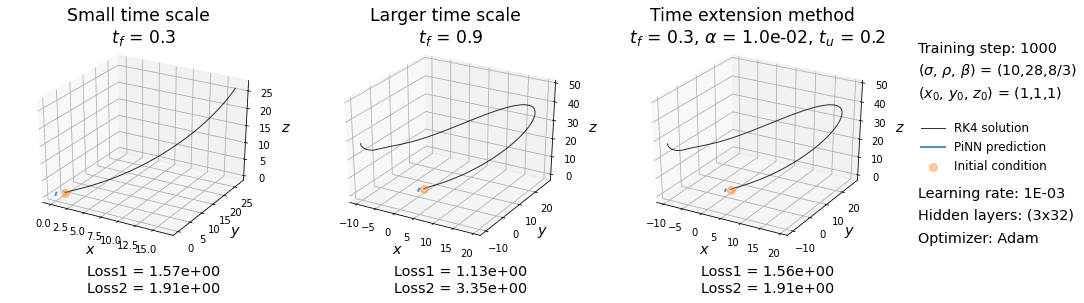

KeyboardInterrupt: ignored

In [6]:
t_physics1 = torch.linspace(ti,tf1,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training for subplot 1
t_physics2 = torch.linspace(ti,tf2,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training for subplot 2

# Create the models -----------------------------------------------------------
model1 = FCN(INPUT,OUTPUT,N_HIDDEN,N_LAYERS) #Create a network with the specified hidden layers and neurons
optimizer1 = torch.optim.Adam(model1.parameters(),lr=lr) #Specify the optimizer and use the learning rate
model2 = FCN(INPUT,OUTPUT,N_HIDDEN,N_LAYERS) 
optimizer2 = torch.optim.Adam(model2.parameters(),lr=lr) 
model3 = FCN(INPUT,OUTPUT,N_HIDDEN,N_LAYERS) 
optimizer3 = torch.optim.Adam(model3.parameters(),lr=lr)

files = [] #Create empty files for the intermediate results for the animation
tf3_list = [] #Empty file for updating of the final time for subplot 3
for i in range(iterations): #Loop over the iterations
    optimizer1.zero_grad() #Set gradients of all optimized tensors to zero
    optimizer2.zero_grad() 
    optimizer3.zero_grad() 
    
    if len(tf3_list) > 0: #For updating the final time3 in the system
        tf3 = tf3_list[-1]
        h = tf3/1000
    t_physics3 = torch.linspace(ti,tf3,n).view(-1,1).requires_grad_(True) #t_physics needs to be re-specified

    #Calculation of loss1 that depends on the initial condition at t=0:
    # Model 1 -----------------------------------------------------------------
    m1 = model1(torch.FloatTensor([0]))
    xh1,yh1,zh1 = m1[0],m1[1],m1[2]
    loss1_1 = torch.mean((xh1-x0)**2 + (yh1-y0)**2 + (zh1-z0)**2)
    # Model 2 -----------------------------------------------------------------
    m2 = model2(torch.FloatTensor([0]))
    xh2,yh2,zh2 = m2[0],m2[1],m2[2]
    loss1_2 = torch.mean((xh2-x0)**2 + (yh2-y0)**2 + (zh2-z0)**2)
    # Model 3 -----------------------------------------------------------------
    m3 = model3(torch.FloatTensor([0]))
    xh3,yh3,zh3 = m3[0],m3[1],m3[2]
    loss1_3 = torch.mean((xh3-x0)**2 + (yh3-y0)**2 + (zh3-z0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    # Model 1 -----------------------------------------------------------------
    p1 = model1(t_physics1)
    px1,py1,pz1 = p1[:,0],p1[:,1],p1[:,2]
    px1,py1,pz1 = px1.view(-1,1),py1.view(-1,1),pz1.view(-1,1) #Correct shape
    dxdt_1 = torch.autograd.grad(px1, t_physics1, torch.ones_like(px1), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt_1 = torch.autograd.grad(py1, t_physics1, torch.ones_like(py1), create_graph=True)[0]
    dzdt_1 = torch.autograd.grad(pz1, t_physics1, torch.ones_like(pz1), create_graph=True)[0]
    physics_x_1 = -sigma*px1 + sigma*py1 - dxdt_1 #Calculate f-residuals for the x,y,z differential equations
    physics_y_1 = -px1*pz1 + rho*px1 - py1 - dydt_1
    physics_z_1 = px1*py1 - beta*pz1 - dzdt_1
    loss2_1 = torch.mean(physics_x_1**2 + physics_y_1**2 + physics_z_1**2) #Total loss2 is the MSE of above residuals
    
    loss_1 = 10*loss1_1 + loss2_1 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss_1.backward() #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer1.step() #parameter += -lr * parameter.grad

    # Model 2 -----------------------------------------------------------------
    p2 = model2(t_physics2)
    px2,py2,pz2 = p2[:,0],p2[:,1],p2[:,2]
    px2,py2,pz2 = px2.view(-1,1),py2.view(-1,1),pz2.view(-1,1) #Correct shape
    dxdt_2 = torch.autograd.grad(px2, t_physics2, torch.ones_like(px2), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt_2 = torch.autograd.grad(py2, t_physics2, torch.ones_like(py2), create_graph=True)[0]
    dzdt_2 = torch.autograd.grad(pz2, t_physics2, torch.ones_like(pz2), create_graph=True)[0]
    physics_x_2 = -sigma*px2 + sigma*py2 - dxdt_2 #Calculate f-residuals for the x,y,z differential equations
    physics_y_2 = -px2*pz2 + rho*px2 - py2 - dydt_2
    physics_z_2 = px2*py2 - beta*pz2 - dzdt_2
    loss2_2 = torch.mean(physics_x_2**2 + physics_y_2**2 + physics_z_2**2) #Total loss2 is the MSE of above residuals
    
    loss_2 = 10*loss1_2 + loss2_2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss_2.backward() #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer2.step() #parameter += -lr * parameter.grad

    # Model 3 -----------------------------------------------------------------
    p3 = model3(t_physics3)
    px3,py3,pz3 = p3[:,0],p3[:,1],p3[:,2]
    px3,py3,pz3 = px3.view(-1,1),py3.view(-1,1),pz3.view(-1,1) #Correct shape
    dxdt_3 = torch.autograd.grad(px3, t_physics3, torch.ones_like(px3), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    dydt_3 = torch.autograd.grad(py3, t_physics3, torch.ones_like(py3), create_graph=True)[0]
    dzdt_3 = torch.autograd.grad(pz3, t_physics3, torch.ones_like(pz3), create_graph=True)[0]
    physics_x_3 = -sigma*px3 + sigma*py3 - dxdt_3 #Calculate f-residuals for the x,y,z differential equations
    physics_y_3 = -px3*pz3 + rho*px3 - py3 - dydt_3
    physics_z_3 = px3*py3 - beta*pz3 - dzdt_3
    loss2_3 = torch.mean(physics_x_3**2 + physics_y_3**2 + physics_z_3**2) #Total loss2 is the MSE of above residuals
    
    loss_3 = 10*loss1_3 + loss2_3 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss_3.backward() #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer3.step() #parameter += -lr * parameter.grad

    if (i+1)%intermediate == 0: #Plot and save intermediate results
        print("PiNN, iteration: {}, time: {}".format(i+1,datetime.now() - time))

        p1 = model1(t_physics1)
        m1_1 = torch.squeeze(p1.detach())
        xh1,yh1,zh1 = m1_1[:,0],m1_1[:,1],m1_1[:,2] #PiNN-predicted results with:
        th1 = torch.linspace(ti,tf1,n).view(-1,1) #corresponding times
        x1,y1,z1 = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,float('%.2g'%(tf1)),n)) #RK4 results with:
        t1 = torch.linspace(ti,tf1,n).view(-1,1) #corresponding times that stays +5 timesteps above the PiNN-predicted result

        p2 = model2(t_physics2)
        m1_2 = torch.squeeze(p2.detach())
        xh2,yh2,zh2 = m1_2[:,0],m1_2[:,1],m1_2[:,2] #PiNN-predicted results with:
        th2 = torch.linspace(ti,tf2,n).view(-1,1) #corresponding times
        x2,y2,z2 = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,float('%.2g'%(tf2)),n)) #RK4 results with:
        t2 = torch.linspace(ti,tf2,n).view(-1,1) #corresponding times that stays +5 timesteps above the PiNN-predicted result

        p3 = model3(t_physics3)
        m1_3 = torch.squeeze(p3.detach())
        xh3,yh3,zh3 = m1_3[:,0],m1_3[:,1],m1_3[:,2] #PiNN-predicted results with:
        th3 = torch.linspace(ti,tf3,n).view(-1,1) #corresponding times
        x3,y3,z3 = torch.FloatTensor(RungeKutta(dxdt_def,dydt_def,dzdt_def, x0,y0,z0, ti,float('%.2g'%(tf2)),n)) #RK4 results with:
        t3 = torch.linspace(ti,tf2,n).view(-1,1) #corresponding times that stays +5 timesteps above the PiNN-predicted result
        
        plot_result(x1,y1,z1, x2,y2,z2, x3,y3,z3, x0,y0,z0, xh1,yh1,zh1, xh2,yh2,zh2, xh3,yh3,zh3) #3D plot 
        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        plt.show() #Show plots

    if loss2_3 < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf3
        tf3_list.append(tf3 + update_t)

#Creating gif-animation:
save_gif("Time_extension.gif", files, fps=20, loop=0)